In [1]:
import numpy as np
from briefcase.case import Case
from briefcase.case_base import CaseBase
import pandas as pd
import matplotlib.pyplot as plt
import TelcoConverter as TC
import seaborn as sns
import random

# Initial Stats 

In [2]:
data = TC.get_existing_test_data()
initial_cases = [Case.from_dict(c) for c in data]
initial_cb = CaseBase(initial_cases)
initial_cb.metrics()
filtered_1perc_power = TC.filter_data_by_power(data, 1)

Loaded data successfully from 'data/telco-corr-test-0.25-False.yaml'
Number of cases:  1413
Number of cases associated with inconsistency:  927
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10


In [3]:
CaseBase([Case.from_dict(c) for c in filtered_1perc_power]).metrics()

Number of cases:  1066
Number of cases associated with inconsistency:  197
Maximum number of edges on a pi case: 523776
Maximum number of edges on a delta case: 523776
Factors for pi: 10
Factors for delta: 10


(1066, 197)

### Starting from an empty casebase how many admissions before we get an inconsistent set?


In [4]:
_, _, _, _, _, _ = TC.test_admit_bf_incons(TC.balanced_shuffle_data(data, 51))

0: The number of cases we can admit before we create an inconsistency 29
0: The power of case base before we create an inconsistency 128768
0: The pi factors on the first inconsistent case 8
0: The delta factors on the first inconsistent case 1
1: The number of cases we can admit before we create an inconsistency 19
1: The power of case base before we create an inconsistency 17728
1: The pi factors on the first inconsistent case 2
1: The delta factors on the first inconsistent case 3

2: The number of cases we can admit before we create an inconsistency 20
2: The power of case base before we create an inconsistency 221076
2: The pi factors on the first inconsistent case 5
2: The delta factors on the first inconsistent case 2

3: The number of cases we can admit before we create an inconsistency 19
3: The power of case base before we create an inconsistency 134128
3: The pi factors on the first inconsistent case 4
3: The delta factors on the first inconsistent case 6

4: The number of c

In [13]:
_, _, _, _, _, _ = TC.test_admit_bf_incons(TC.balanced_shuffle_data(filtered_1perc_power, 51))

0: The number of cases we can admit before we create an inconsistency 32
0: The power of case base before we create an inconsistency 12189
0: The pi factors on the first inconsistent case 1
0: The delta factors on the first inconsistent case 1
1: The number of cases we can admit before we create an inconsistency 183
1: The power of case base before we create an inconsistency 42083
1: The pi factors on the first inconsistent case 2
1: The delta factors on the first inconsistent case 1

2: The number of cases we can admit before we create an inconsistency 18
2: The power of case base before we create an inconsistency 6796
2: The pi factors on the first inconsistent case 1
2: The delta factors on the first inconsistent case 3
3: The number of cases we can admit before we create an inconsistency 48
3: The power of case base before we create an inconsistency 15909
3: The pi factors on the first inconsistent case 3
3: The delta factors on the first inconsistent case 5

4: The number of cases

# Factors

Number of cases with an empty factorset side 347 which are filtered out


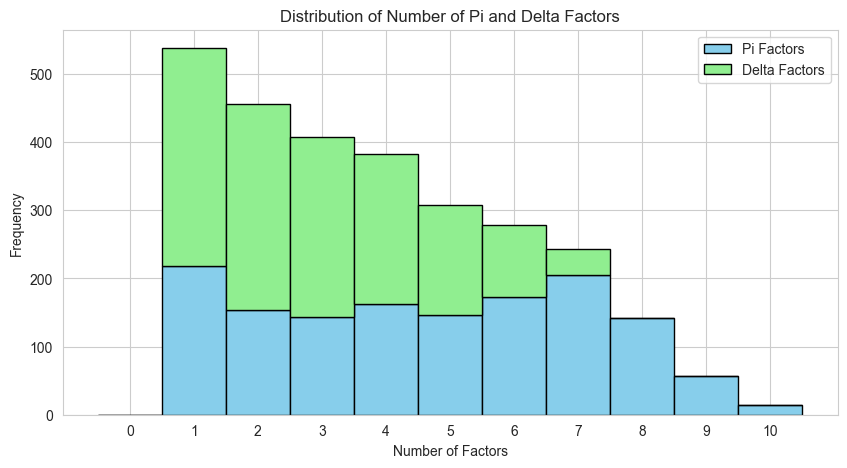

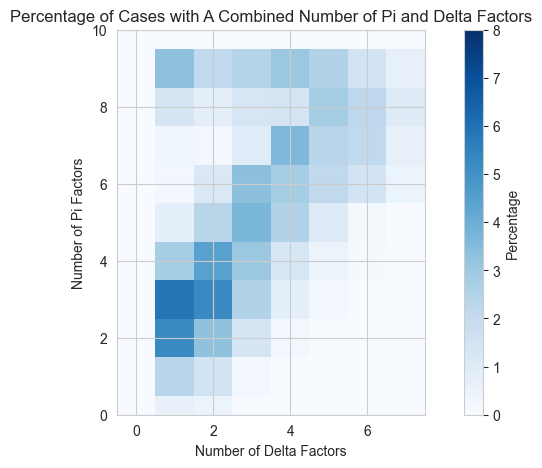

In [73]:
def factors_descriptive_stats(data):
    cases = [Case.from_dict(c) for c in data]
    cb = CaseBase(cases)
    filtered_cases = cb.cases # filtered out the empty side cases
    
    print(f"Number of cases with an empty factorset side {len(cases)-len(filtered_cases)} which are filtered out")
    
    pi_counts = []  # Store the number of pi factors for each case
    delta_counts = []  # Store the number of delta factors for each case
    
    
    for case in filtered_cases:
        count_pi = len(case.pi_factors)
        count_delta = len(case.delta_factors)
        pi_counts.append(count_pi)
        delta_counts.append(count_delta)
    
    # Plot histogram with stacked bars
    plt.figure(figsize=(10, 5))
    plt.hist([pi_counts, delta_counts], bins=range(max(max(pi_counts), max(delta_counts)) + 2), color=['skyblue', 'lightgreen'], label=['Pi Factors', 'Delta Factors'], edgecolor='black', align='left', stacked=True)
    
    plt.xlabel('Number of Factors')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Pi and Delta Factors')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(max(max(pi_counts), max(delta_counts)) + 1))
    plt.show()
        
    # Calculate total number of cases
    total_cases = len(pi_counts)
    
    # Calculate co-occurrence matrix
    cooccurrence_matrix = np.zeros((max(pi_counts) + 1, max(delta_counts) + 1))
    for pi, delta in zip(pi_counts, delta_counts):
        cooccurrence_matrix[pi, delta] += 1
    
    # Divide each element in the co-occurrence matrix by the total number of cases to get percentages
    cooccurrence_matrix_percentage = (cooccurrence_matrix / total_cases) * 100
    
    # Flip the co-occurrence matrix
    cooccurrence_matrix_percentage = np.flipud(cooccurrence_matrix_percentage)
    
    # Create heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(cooccurrence_matrix_percentage, cmap='Blues', vmin=0, vmax=8, interpolation='nearest')
    plt.colorbar(label='Percentage')
    plt.xlabel('Number of Delta Factors')
    plt.ylabel('Number of Pi Factors')
    plt.title('Percentage of Cases with A Combined Number of Pi and Delta Factors')
    plt.grid(True)
    
    # Set the extent of the y-axis
    plt.ylim(0, max(pi_counts))
    
    plt.show()
    
factors_descriptive_stats(data)

Number of cases with an empty factorset side 347 which are filtered out


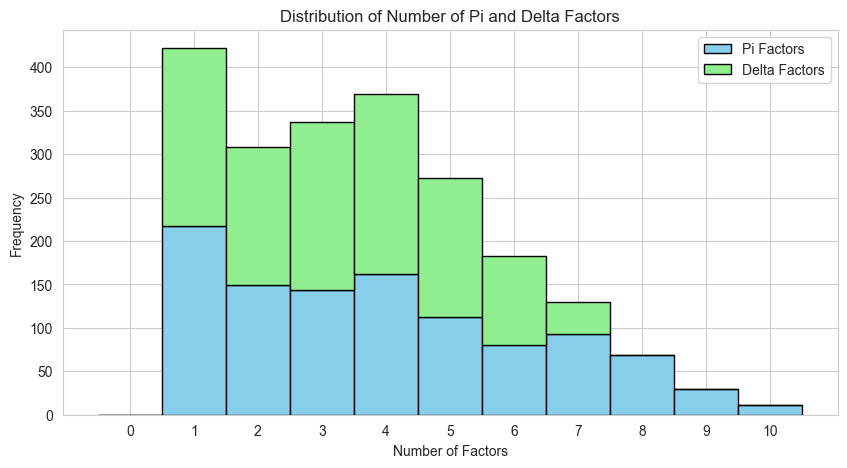

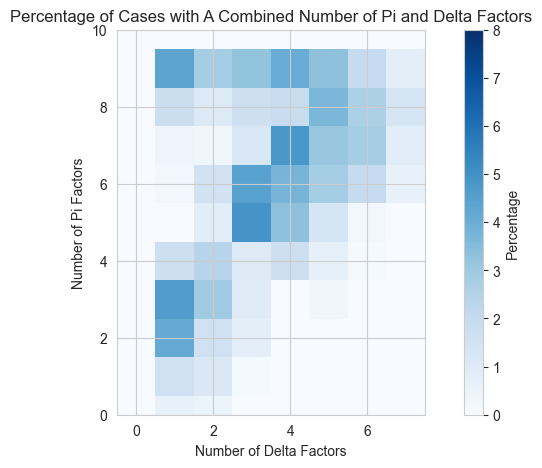

In [74]:
factors_descriptive_stats(filtered_1perc_power)

In [49]:
def incons_percentage(pi_df, delta_df):
    # Count the number of inconsistent factors for each factor name
    inconsistent_counts_pi = pi_df.transpose().apply(pd.Series.value_counts).fillna(0).astype(int).transpose()
    inconsistent_counts_delta = delta_df.transpose().apply(pd.Series.value_counts).fillna(0).astype(int).transpose()
    
    # Calculate the percentage of inconsistency for each factor
    total_cases = len(pi_df.transpose())
    inconsistent_percentage_pi = (inconsistent_counts_pi[1.0] / total_cases) * 100
    inconsistent_percentage_delta = (inconsistent_counts_delta[1.0] / total_cases) * 100
    
    return inconsistent_percentage_pi, inconsistent_percentage_delta

def test_factor_incons(data, repeats):
    _, _, _, _, pi_df, delta_df = TC.test_admit_bf_incons(TC.balanced_shuffle_data(data, repeats))

    # 1. Factors More Likely to be Inconsistent
    inconsistent_percentage_pi, inconsistent_percentage_delta = incons_percentage(pi_df, delta_df)
    return inconsistent_percentage_pi, inconsistent_percentage_delta, pi_df, delta_df
    
def experiment_factor_incons(data, repeats):
    inconsistent_percentage_pi, inconsistent_percentage_delta, pi_df, delta_df = test_factor_incons(data, repeats)
    
    # Visualize the distribution of inconsistency across factors
    plt.figure(figsize=(10, 5))
    sns.barplot(x=inconsistent_percentage_pi.index, y=inconsistent_percentage_pi.values)
    plt.title(f"Percentage of First Inconsistent Cases Featuring Pi Factor ({repeats} trials)")
    plt.xlabel("Factor")
    plt.ylabel("Percentage of Inconsistent Cases")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Visualize the distribution of inconsistency across factors
    plt.figure(figsize=(10, 5))
    sns.barplot(x=inconsistent_percentage_delta.index, y=inconsistent_percentage_delta.values)
    plt.title(f"Percentage of First Inconsistent Cases Featuring Delta Factor ({repeats} trials)")
    plt.xlabel("Factor")
    plt.ylabel("Percentage of Inconsistent Cases")
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Compute the frequency of co-occurrence of inconsistencies between pairs of factors
    cooccurrence_matrix_pi = pi_df.fillna(0).transpose().corr()
    
    # Visualize the co-occurrence matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cooccurrence_matrix_pi, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
    plt.title(f"Heatmap of Co-occurence of Pi Factors in First Inconsistent Cases ({repeats} trials)")
    plt.xlabel("Factors")
    plt.ylabel("Factors")
    plt.show()
    
    # Compute the frequency of co-occurrence of inconsistencies between pairs of factors
    cooccurrence_matrix_delta = delta_df.fillna(0).transpose().corr()
    
    # Visualize the co-occurrence matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cooccurrence_matrix_delta, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5)
    plt.title(f"Heatmap of Co-occurence of Delta Factors in First Inconsistent Cases ({repeats} trials)")
    plt.xlabel("Factors")
    plt.ylabel("Factors")
    plt.show()

0: The number of cases we can admit before we create an inconsistency 29
0: The power of case base before we create an inconsistency 128768
0: The pi factors on the first inconsistent case 8
0: The delta factors on the first inconsistent case 1

1: The number of cases we can admit before we create an inconsistency 19
1: The power of case base before we create an inconsistency 17728
1: The pi factors on the first inconsistent case 2
1: The delta factors on the first inconsistent case 3

2: The number of cases we can admit before we create an inconsistency 20
2: The power of case base before we create an inconsistency 221076
2: The pi factors on the first inconsistent case 5
2: The delta factors on the first inconsistent case 2

3: The number of cases we can admit before we create an inconsistency 19
3: The power of case base before we create an inconsistency 134128
3: The pi factors on the first inconsistent case 4
3: The delta factors on the first inconsistent case 6
4: The number of c

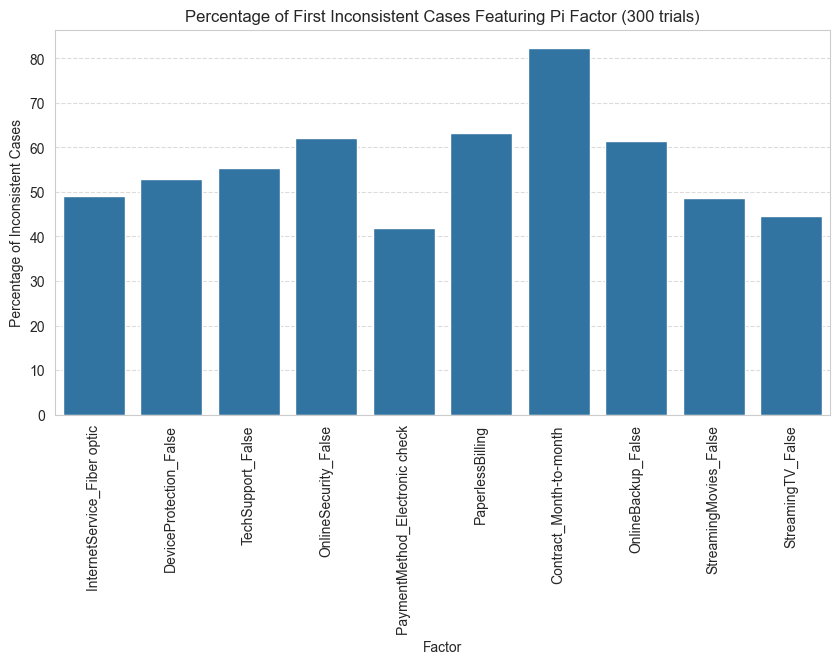

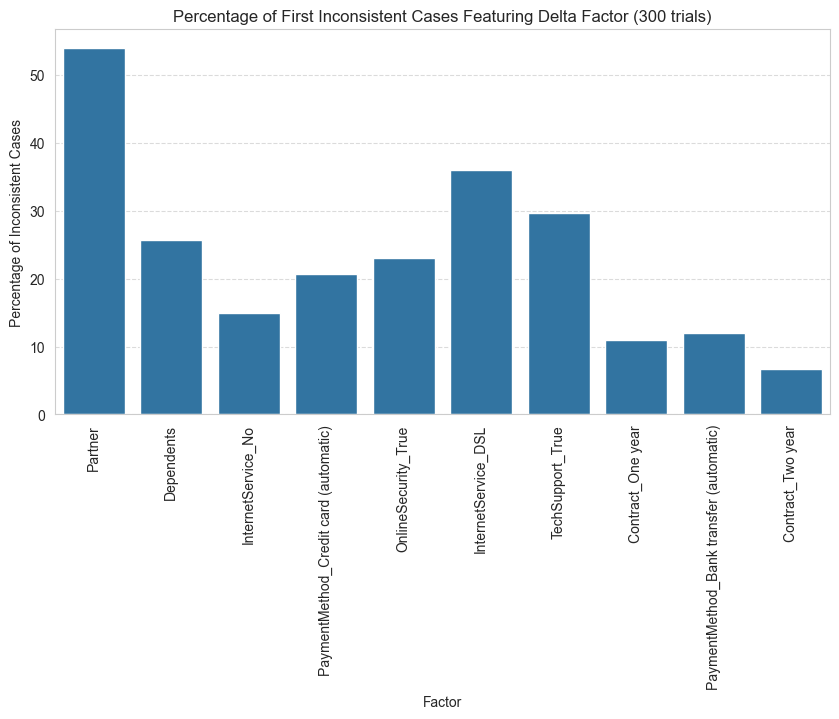

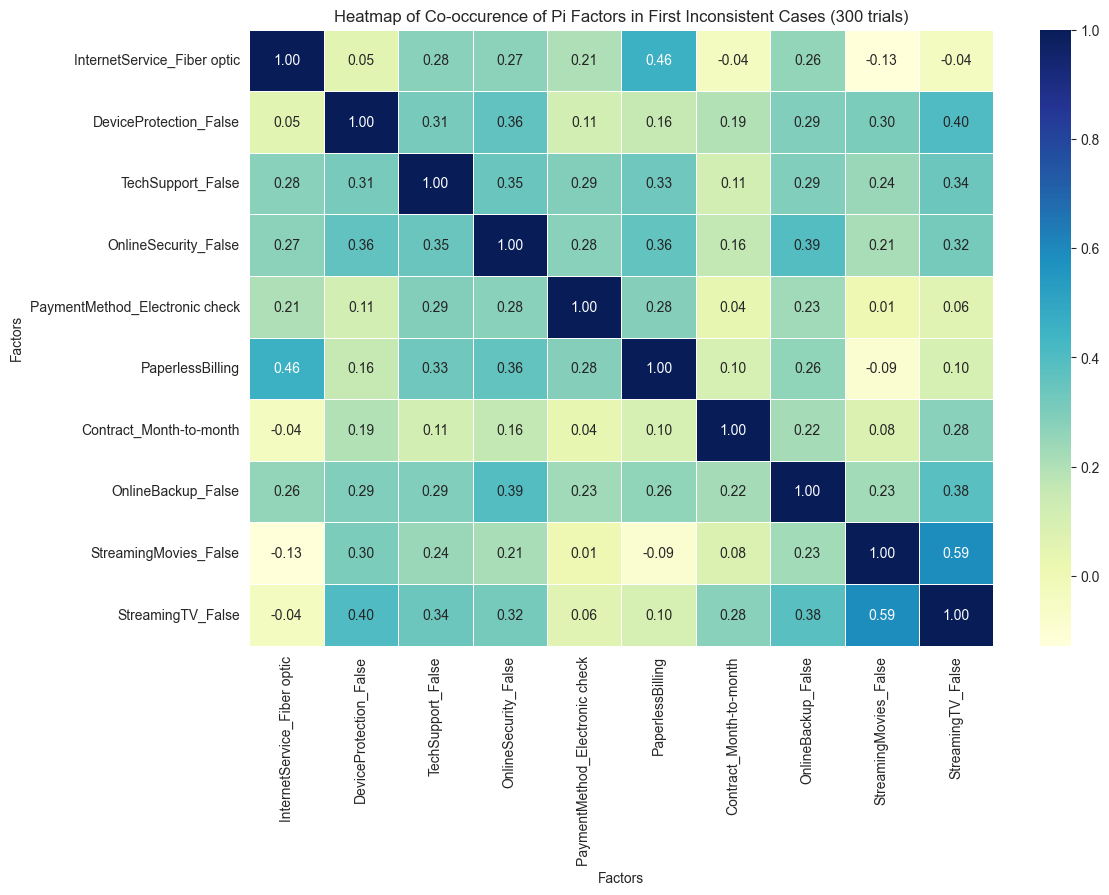

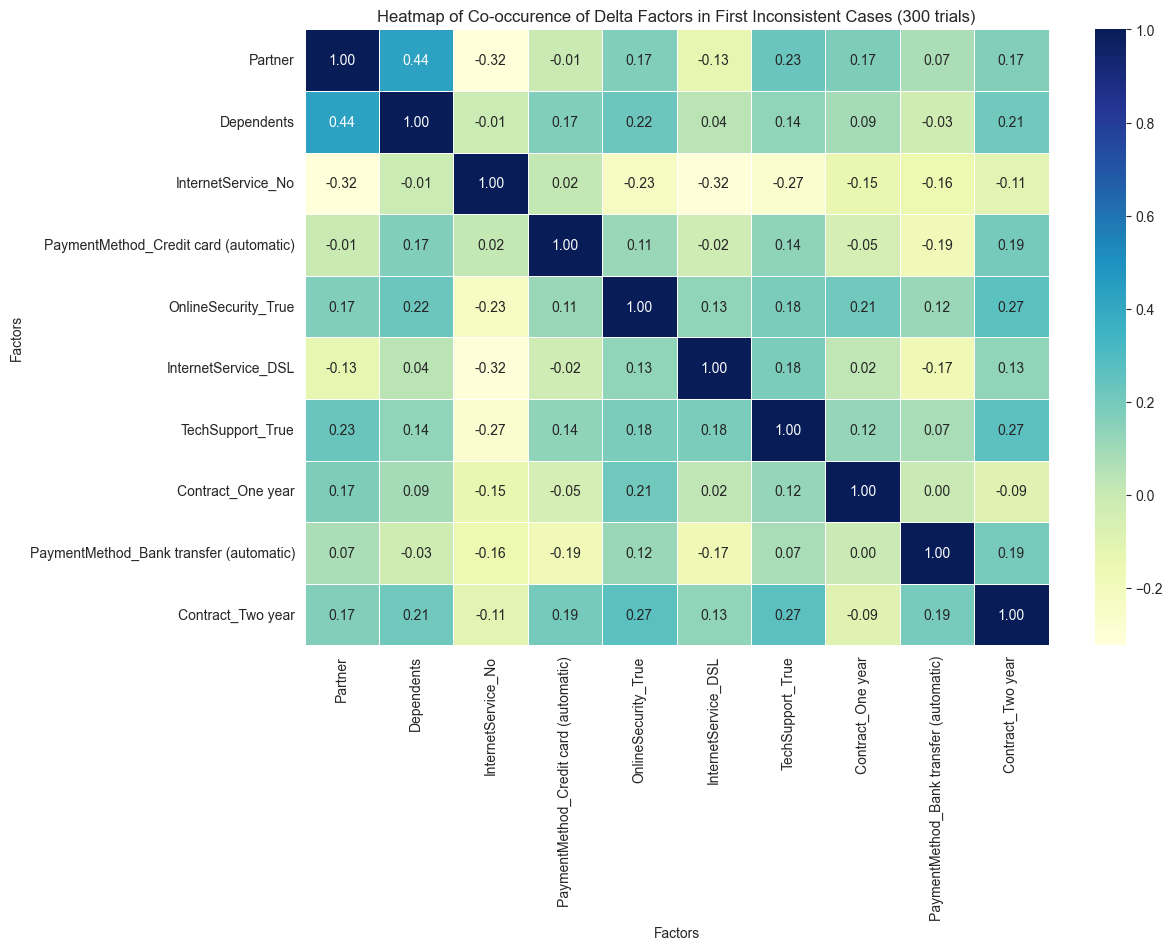

In [50]:
experiment_factor_incons(data, repeats=300)

0: The number of cases we can admit before we create an inconsistency 32
0: The power of case base before we create an inconsistency 12189
0: The pi factors on the first inconsistent case 1
0: The delta factors on the first inconsistent case 1
1: The number of cases we can admit before we create an inconsistency 183
1: The power of case base before we create an inconsistency 42083
1: The pi factors on the first inconsistent case 2
1: The delta factors on the first inconsistent case 1

2: The number of cases we can admit before we create an inconsistency 18
2: The power of case base before we create an inconsistency 6796
2: The pi factors on the first inconsistent case 1
2: The delta factors on the first inconsistent case 3
3: The number of cases we can admit before we create an inconsistency 48
3: The power of case base before we create an inconsistency 15909
3: The pi factors on the first inconsistent case 3
3: The delta factors on the first inconsistent case 5

4: The number of cases

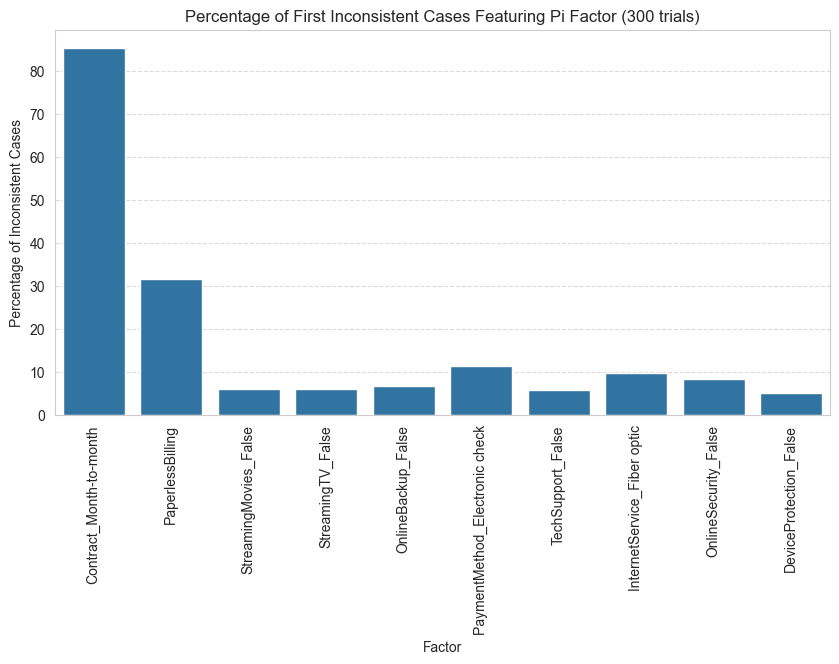

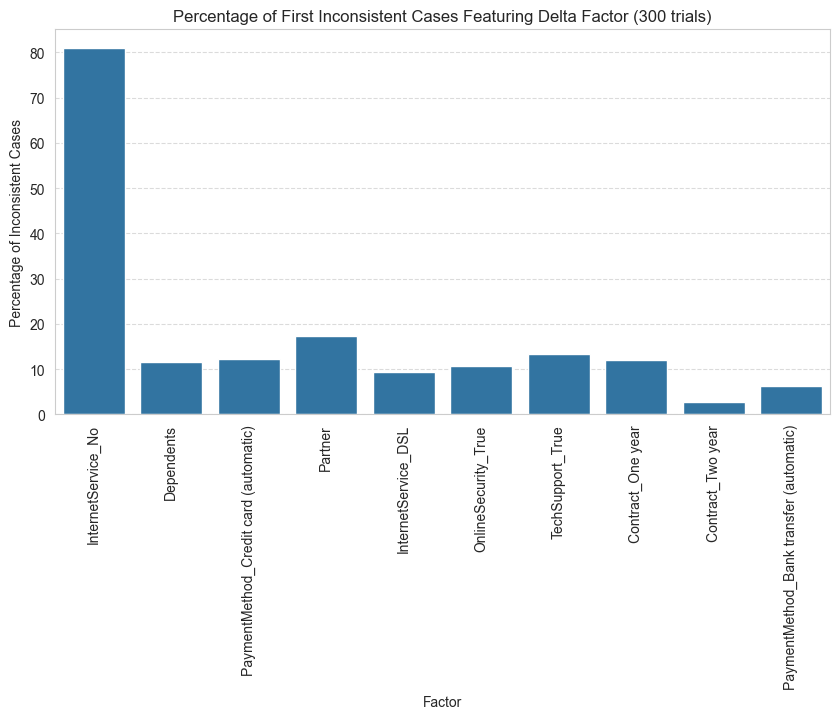

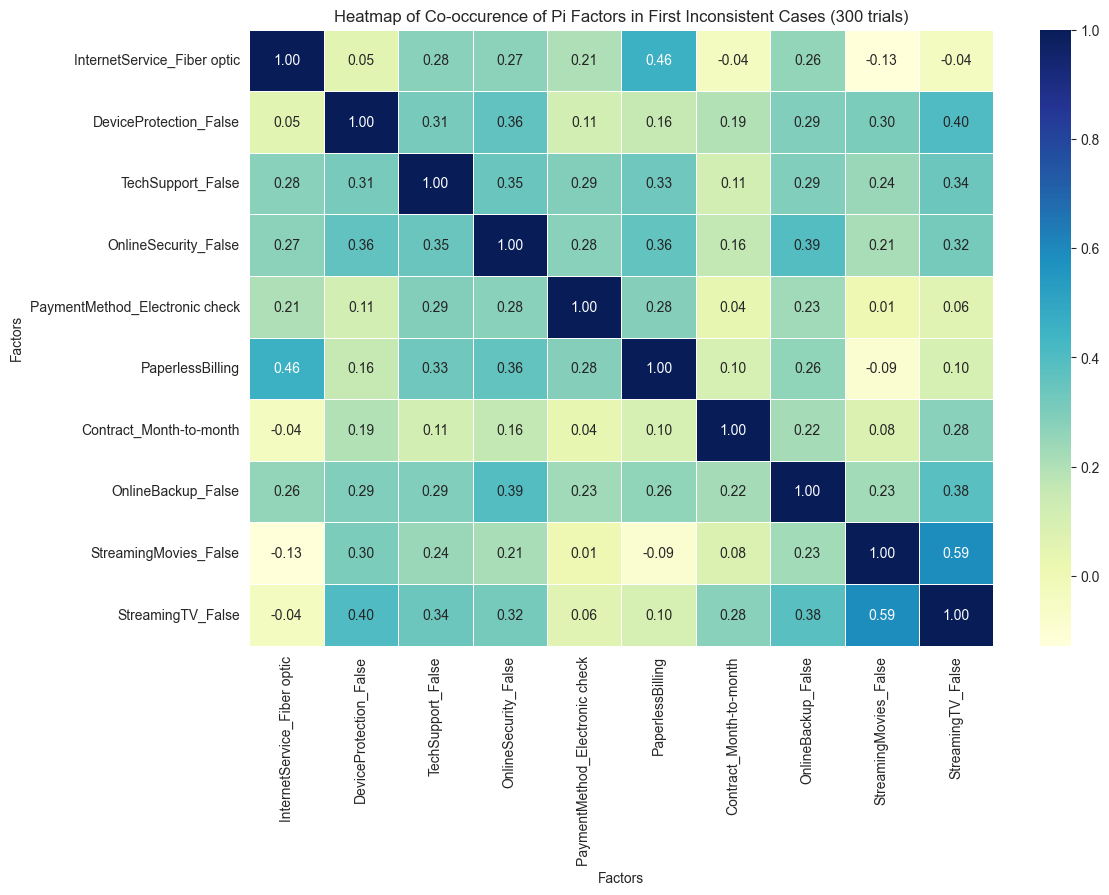

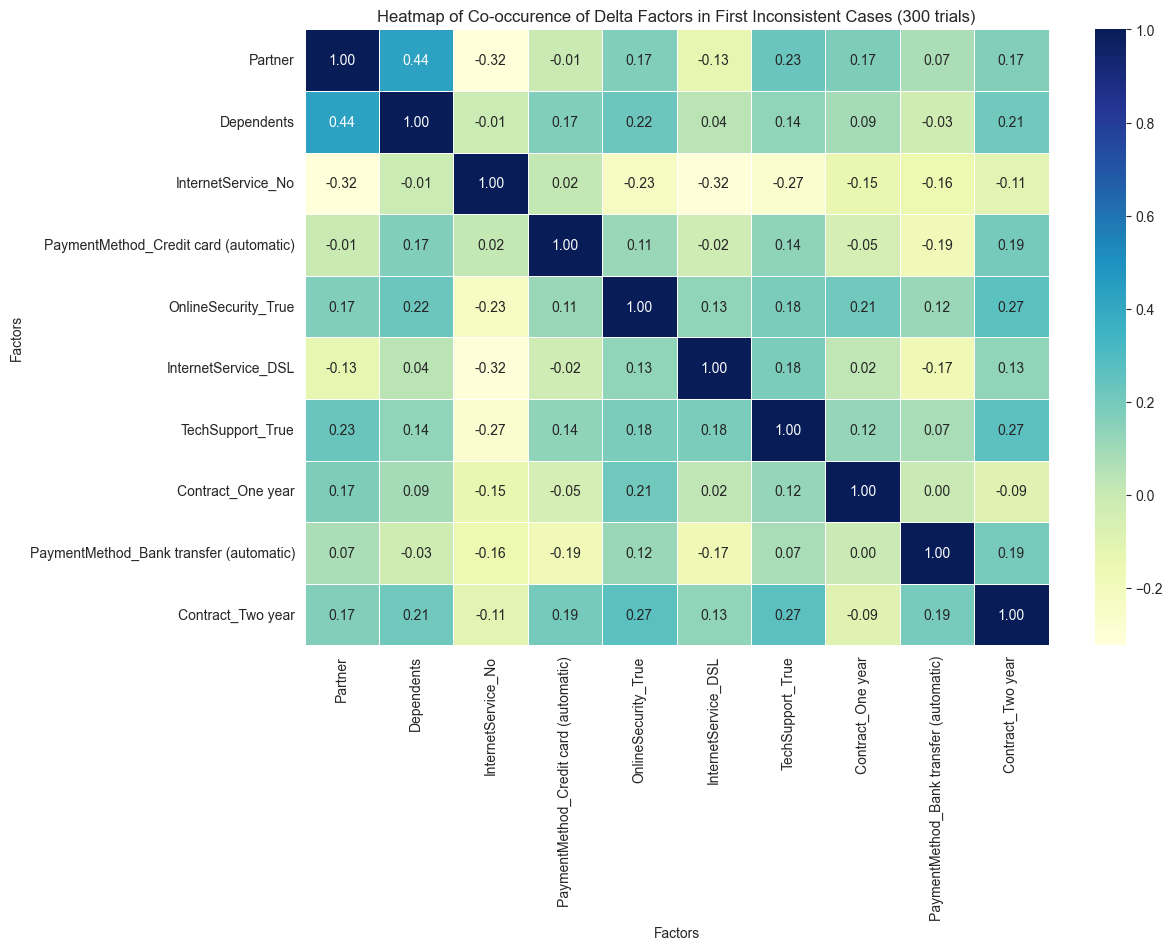

In [51]:
experiment_factor_incons(filtered_1perc_power, repeats=300)

## Remove factors over % inconsistency occurrence

In [54]:
from sklearn.model_selection import train_test_split

def remove_factors_data(train_data, pi_factors, delta_factors):
    df = pd.DataFrame(train_data)
    # Remove factors from PI_factors column
    df['pi'] = df['pi'].apply(lambda x: [factor for factor in x if factor in pi_factors])
    # Remove factors from Delta_factors column
    df['delta'] = df['delta'].apply(lambda x: [factor for factor in x if factor in delta_factors])
    
    df['reason'] = df['reason'].apply(lambda x: [factor for factor in x if factor in delta_factors or factor in pi_factors])
    return df

def remove_factors_incons(train_data, inconsistent_percentage_pi, inconsistent_percentage_delta, perc):
    # Filter factors with inconsistency occurrence over %
    filtered_factors_pi = inconsistent_percentage_pi[inconsistent_percentage_pi <= perc]
    filtered_factors_delta = inconsistent_percentage_delta[inconsistent_percentage_delta <= perc]
    
    # Get the names of factors to keep
    factors_to_keep_pi = filtered_factors_pi.index.tolist()
    factors_to_keep_delta = filtered_factors_delta.index.tolist()
    
    new_data = remove_factors_data(train_data, factors_to_keep_pi, factors_to_keep_delta).to_dict(orient='records')
    return new_data
    
def remove_factors_experiment(data):
    percentages = [20, 30, 40, 50, 60, 70, 80, 90, 100]
    train_data, test_data = train_test_split(data, test_size=0.5, random_state=42)
    repeats_train = 300
    repeats_test = 300
    incons_perc_pi_tr, incons_perc_delta_tr = test_factor_incons(train_data, repeats_train)
    test_data_shuffles = TC.shuffle_data(test_data, repeats_test)
    avgs = []
    stds = []
    for perc in percentages:
        print(f"\n\nPercentage inconsistency of factors {perc}")
        filtered_shuffles = []
        for shuffle in test_data_shuffles:
            filtered_shuffles.append(remove_factors_incons(shuffle, incons_perc_pi_tr, incons_perc_delta_tr, perc))
        _, _, avg, std, _, _ = TC.test_admit_bf_incons(filtered_shuffles)
        avgs.append(avg)
        stds.append(std)
        
    # Visualize the results
    plt.errorbar(percentages, avgs, yerr=stds, fmt='o', capsize=5)
    plt.xlabel(f'Percentage of inconsistent training cases with factor - {repeats_train} trials')
    plt.ylabel(f'Average cases before inconsistency - {repeats_test} trials')
    plt.title('Effect of removing factors which are more likely to be associated with inconsistency')
    plt.grid(True)
    plt.show()

0: The number of cases we can admit before we create an inconsistency 60
0: The power of case base before we create an inconsistency 11056
0: The pi factors on the first inconsistent case 1
0: The delta factors on the first inconsistent case 3

1: The number of cases we can admit before we create an inconsistency 49
1: The power of case base before we create an inconsistency 12987
1: The pi factors on the first inconsistent case 2
1: The delta factors on the first inconsistent case 1
2: The number of cases we can admit before we create an inconsistency 44
2: The power of case base before we create an inconsistency 8738
2: The pi factors on the first inconsistent case 2
2: The delta factors on the first inconsistent case 1
3: The number of cases we can admit before we create an inconsistency 87
3: The power of case base before we create an inconsistency 21498
3: The pi factors on the first inconsistent case 3
3: The delta factors on the first inconsistent case 1

4: The number of cases 

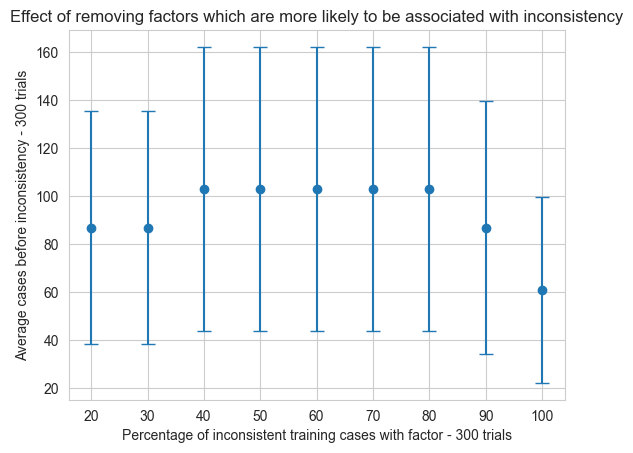

In [55]:
remove_factors_experiment(filtered_1perc_power)

# Strength Experiment

In [93]:
def test_powers(data):
    cases = [Case.from_dict(c) for c in data]
    cb = CaseBase(cases)
    filtered_cases = cb.cases # filtered out the empty side cases
    powers = []
    for case in filtered_cases:
        power = cb.order.PD.case_power(case)
        powers.append(power)
        if power == 0: 
            print(case)
    
    return powers

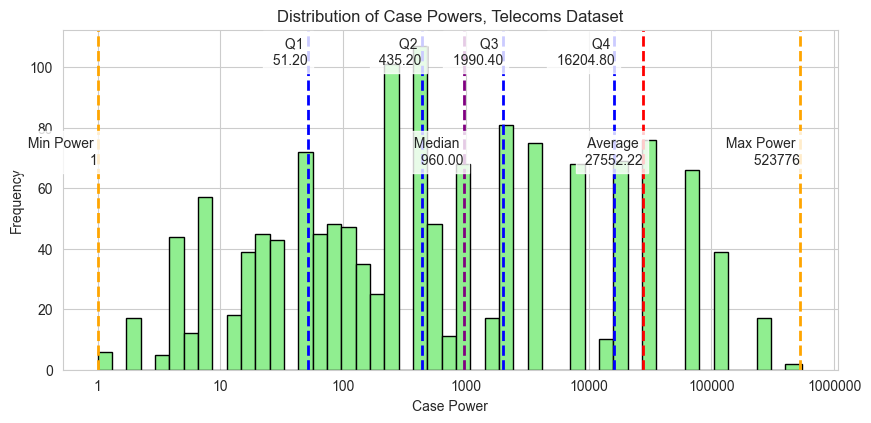

In [94]:
def display_case_powers(data):
    powers = test_powers(data)

    # Assuming 'powers' is your data
    unique_powers, power_counts = np.unique(powers, return_counts=True)
    
    # Calculate quintiles
    power_quintiles = np.percentile(unique_powers, [20, 40, 60, 80])
    
    # Calculate bin edges
    bin_edges = np.logspace(np.log10(min(unique_powers)), np.log10(max(unique_powers)), 50)
    bin_edges[-1] *= 1.05  # Extend the last bin to ensure it includes the maximum power value
    
    # Plotting the histogram with a log scale on the x-axis
    plt.figure(figsize=(10, 5))
    plt.hist(powers, bins=bin_edges, color='lightgreen', edgecolor='black')
    plt.xscale('log')
    plt.title('Distribution of Case Powers, Telecoms Dataset')
    plt.xlabel('Case Power')
    plt.ylabel('Frequency')
    plt.grid(True, axis='y')  # Grid on y-axis only for better visibility of frequencies
    
    # Define tick positions for the x-axis
    tick_positions = [1, 10, 100, 1000, 10000, 100000, 1000000]
    
    # Set custom ticks and labels for the x-axis
    plt.xticks(tick_positions, [str(int(tick)) for tick in tick_positions])
    
    # Mark quintiles and their original power numbers
    for quintile in power_quintiles:
        plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
        plt.text(quintile, 100, f' Q{np.where(power_quintiles == quintile)[0][0] + 1} \n {quintile:.2f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin
    
    # Mark the average
    power_average = np.mean(unique_powers)
    plt.axvline(power_average, color='red', linestyle='dashed', linewidth=2)
    plt.text(power_average, max(power_counts)+10, f' Average \n {power_average:.2f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    
    # Calculate median
    power_median = np.median(unique_powers)
    plt.axvline(power_median, color='purple', linestyle='dashed', linewidth=2)
    plt.text(power_median, max(power_counts)+10, f' Median \n {power_median:.2f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    
    # Mark the maximum power possible
    max_power = max(unique_powers)
    plt.axvline(max_power, color='orange', linestyle='dashed', linewidth=2)
    plt.text(max_power, max(power_counts)+10, f' Max Power \n {max_power}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    
    # Mark the minimum power possible
    min_power = min(unique_powers)
    plt.axvline(min_power, color='orange', linestyle='dashed', linewidth=2)
    plt.text(min_power, max(power_counts)+10, f' Min Power \n {min_power}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()
    
display_case_powers(data)

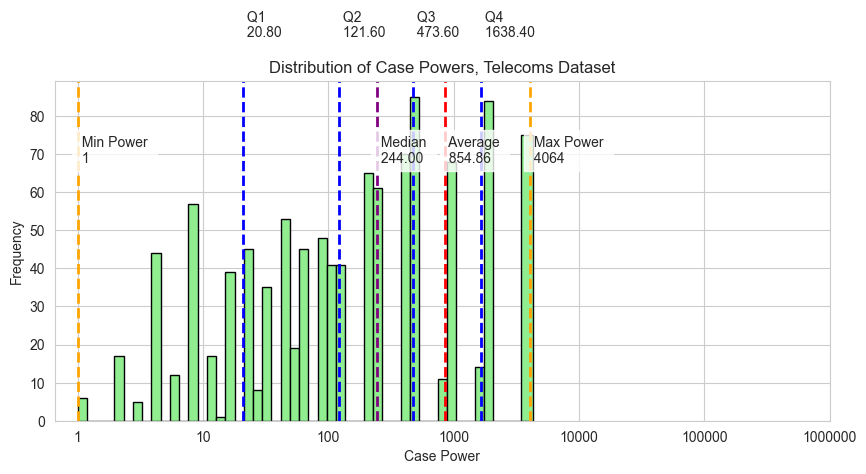

In [5]:
display_case_powers(filtered_1perc_power)

In [6]:
repeats = 100
scores, powers, _, _, _, _ = TC.test_admit_bf_incons(TC.shuffle_data(filtered_1perc_power, repeats))

0: The number of cases we can admit before we create an inconsistency 5
0: The power of case base before we create an inconsistency 1189
0: The pi factors on the first inconsistent case 1
0: The delta factors on the first inconsistent case 1

1: The number of cases we can admit before we create an inconsistency 19
1: The power of case base before we create an inconsistency 10816
1: The pi factors on the first inconsistent case 1
1: The delta factors on the first inconsistent case 1

2: The number of cases we can admit before we create an inconsistency 7
2: The power of case base before we create an inconsistency 8400
2: The pi factors on the first inconsistent case 1
2: The delta factors on the first inconsistent case 1

3: The number of cases we can admit before we create an inconsistency 42
3: The power of case base before we create an inconsistency 12545
3: The pi factors on the first inconsistent case 3
3: The delta factors on the first inconsistent case 4
4: The number of cases we

In [7]:
import statistics

avg = round(sum(scores) / repeats)
std_dev = round(statistics.stdev(scores), 2)
print(f"Average cases before inconsistency ({repeats} trials): {avg}")
print(f"Standard deviation: {std_dev}")


avg = round(sum(powers) / repeats)
std_dev = round(statistics.stdev(powers), 2)
print(f"Average power score ({repeats} trials): {avg}")
print(f"Standard deviation: {std_dev}")

Average cases before inconsistency (100 trials): 67
Standard deviation: 47.53
Average power score (100 trials): 21823
Standard deviation: 12752.96


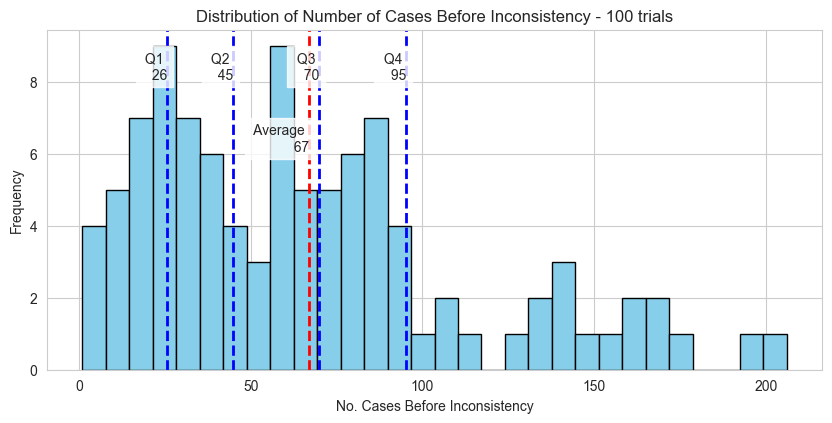

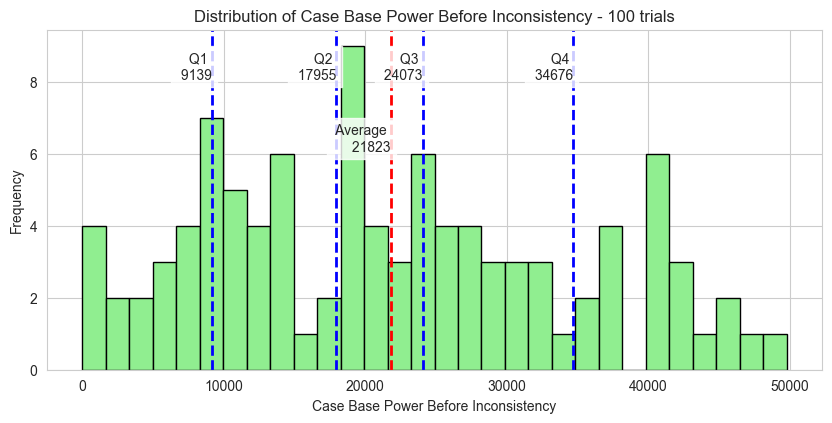

In [12]:
# Calculating quintiles
score_quintiles = np.percentile(scores, [20, 40, 60, 80])
power_quintiles = np.percentile(powers, [20, 40, 60, 80])

# Calculate averages
score_average = np.mean(scores)
power_average = np.mean(powers)

# Plotting inconsistency scores with quintiles
plt.figure(figsize=(10, 5))
plt.hist(scores, bins=30, color='skyblue', edgecolor='black')

# Mark quintiles and their original power numbers
for quintile in score_quintiles:
    plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
    plt.text(quintile, 8, f' Q{np.where(score_quintiles == quintile)[0][0] + 1} \n {quintile:.0f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.axvline(score_average, color='red', linestyle='dashed', linewidth=2)
plt.text(score_average, 6, f' Average \n {score_average:.0f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin

plt.title(f'Distribution of Number of Cases Before Inconsistency - {repeats} trials')
plt.xlabel('No. Cases Before Inconsistency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting power scores with quintiles
plt.figure(figsize=(10, 5))
plt.hist(powers, bins=30, color='lightgreen', edgecolor='black')

# Mark quintiles and their original power numbers
for quintile in power_quintiles:
    plt.axvline(quintile, color='blue', linestyle='dashed', linewidth=2)
    plt.text(quintile, 8, f' Q{np.where(power_quintiles == quintile)[0][0] + 1} \n {quintile:.0f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.axvline(power_average, color='red', linestyle='dashed', linewidth=2)
plt.text(power_average, 6, f' Average \n {power_average:.0f}', verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin

plt.title(f'Distribution of Case Base Power Before Inconsistency - {repeats} trials')
plt.xlabel('Case Base Power Before Inconsistency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Cases under a certain percentage power from max, removed, how it affects inconsistency


Percentage inconsistency of factors 1
0: The number of cases we can admit before we create an inconsistency 5
0: The power of case base before we create an inconsistency 1189
0: The pi factors on the first inconsistent case 1
0: The delta factors on the first inconsistent case 1

1: The number of cases we can admit before we create an inconsistency 19
1: The power of case base before we create an inconsistency 10816
1: The pi factors on the first inconsistent case 1
1: The delta factors on the first inconsistent case 1

2: The number of cases we can admit before we create an inconsistency 7
2: The power of case base before we create an inconsistency 8400
2: The pi factors on the first inconsistent case 1
2: The delta factors on the first inconsistent case 1

3: The number of cases we can admit before we create an inconsistency 42
3: The power of case base before we create an inconsistency 12545
3: The pi factors on the first inconsistent case 3
3: The delta factors on the first incons

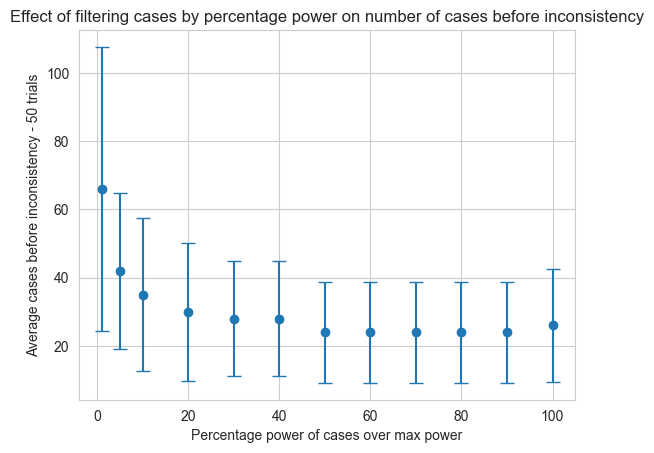

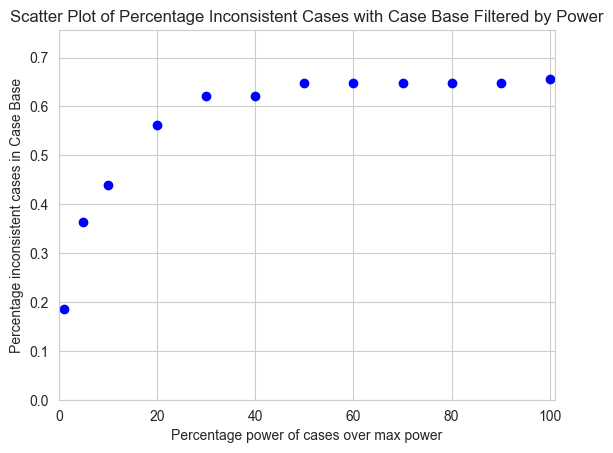

In [13]:
def power_remover_incons_experiment(data, repeats=100):
    percentages = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    avgs = []
    stds = []
    cb_incons =  []
    for perc in percentages:
        power_reduced_data = TC.filter_data_by_power(data[:], perc)
        shuffles = TC.shuffle_data(power_reduced_data, repeats)
        print(f"\nPercentage inconsistency of factors {perc}")
        _, _, avg, std, _, _ = TC.test_admit_bf_incons(shuffles)
        avgs.append(avg)
        stds.append(std)
        
        cb1 = CaseBase(Case.from_dict(c) for c in power_reduced_data)
        cb_incons.append(cb1.count_tainted_cases()/len(cb1.cases))
            
    # Visualize the results
    plt.errorbar(percentages, avgs, yerr=stds, fmt='o', capsize=5)
    plt.xlabel(f'Percentage power of cases over max power')
    plt.ylabel(f'Average cases before inconsistency - {repeats} trials')
    plt.title('Effect of filtering cases by percentage power on number of cases before inconsistency')
    plt.grid(True)
    plt.show()
    
    # Visualize the results
    plt.scatter(percentages, cb_incons, color='blue', label='Data Points')
    plt.xlabel('Percentage power of cases over max power')
    plt.ylabel('Percentage inconsistent cases in Case Base')
    plt.title('Scatter Plot of Percentage Inconsistent Cases with Case Base Filtered by Power')
    plt.xlim(0, max(percentages)+1)
    plt.ylim(0, max(cb_incons)+0.1)
    
power_remover_incons_experiment(data, 50)